# Abstract 

##### La idea de esta notebook es evaluar y poder predecir por cada pais los contagios y las muertes obsercando del data set datos como pueden llegar a ser los casos ya activos el ratio de reproduccion del virus la poblacion de cada pais, el porcetaje de la poblacion que es mayor de edad o factor de riesgo etc, y ver como esto impacta en lo antes mecionado. El data frame tambien cuneta con informacion relevante en cuanto a las instalaciones santirias de los paises como pueden ser las camas diponibles y ocupadas de terapia intesiva, la cantidad de la poblacion con acceso a intalacions basicas de higiene, todo esto lo cual puede llegar a ser relevante al momento de ver el comportamiento del virus en el tiempo.

# Contexto Analitico

##### Para llevar a cabo nuestro analisis contamos con un data set obtenido por la pagina keaggle pero que tambien cuenta con un repositorio de github donde se encuentra mejor explicado y con todas sus fuentes de informacion (https://github.com/owid/covid-19-data/tree/master/public/data)

# Objetivo

##### El objetivo principal de este notebook es poder armar un modelo que pueda predecir con un minimo de exactitud los nuevos casos que se puedan dar asi como tambien las nuevas muertes para esto resumidamente haremos lo siguente:

##### En primer lugar importaremos las librerias que usaremos durate el desarrolo del proyecto.

##### Luego comenzaremos con un analisis exploratorio de los datos, donde se intentara mostrar informacion relevante del data set, donde tambien moldearemos un poco la base da datos para que no sea tan extenso. 

##### En tercer instacia comezaremos ahora si con el Data Wrangling aplicando metodos de Featured Selection para la eliminacion de outliers y para luego poder generar los modelos.

##### Continuaremos con la creacion de los modelos con los resultados obtenidos en la instacia anterior selccioncionado tambien cual de todas las features selection antes relizadas funcioa mejor con nuestra informacion.

# Preguntas

##### El dataframe (df de ahora en adelante) proporciona como mencione antes varias instalaciones "sanitarias" que tiene el pais, una de las prguntas que nos podemos hacer en base a esto es ver que tanto influye o influyo que cada pais tenga o no estas instalaciones en el crecimiento o decrecimiento de los casos. 

##### Tambien el df porporcina informacion sobre las vacunaciones, teniendo en cuenta esto podemos ver la influencia de las vacunaciones en los casos nuevos, pero principalmente nos interesa ver que modificacion genero en las nuevas muertes, ya que el objetivo final de la vacuna no es evitar el contagio sino evitar la muerte.

##### Tambien contamos con datos como puede ser el *stringency_index* que es basicamente como el pais responde en base al progreso del virus generando cuarentenas o prohibiendo ciertas avtividades como pueden ser la presencialidad en los colegios, con esta data podemos ver si la "cuarentena" fue realmente efectiva en ciertos casos. 

##### Respondiendo estas y otras preguntas que se generan mas adelante intentaremos predecir no solo los nuevos casos sino tambien las nuevas muertes que se pueden llegar a generar a causa del virus.


# 1. Importacion de librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from   scipy import stats
import statsmodels.formula.api as sm
import chart_studio.plotly     as py
from bokeh.resources import INLINE
import bokeh.io
from bokeh import *
import pingouin
from IPython.display import display
from ipywidgets import Dropdown
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import math

## 1.2 Carga del dataset con pandas

In [2]:
df = pd.read_csv("..\DataSets\owid-covid-data.csv")
df['Porcentaje_contagios'] = (df['total_cases'] / df['population']) * 100
df.shape
#df.columns

(220343, 68)

# 2. Analisis Exploratorio de Datos (EDA)

## 2.1 limpieza de la base datos (Data Wrangling)
##### Elimino algunas columnas que no voy a estar usando para el analisis junto con los valores tipo Nan que pueden entorpecer tanto las graficas como los datos luego

In [3]:
#reemplazo de los string NaN por el nan de numpy.
df.replace('NaN',np.nan,inplace= True)

df.replace('0',np.nan,inplace=True)

##### Ahora vamos a tomar nuestro df y voy a analizar en cada colunma de interes si estos tiene al menos el 60% de los datos no nulos, si el pais tiene alguna de estas colunmas de interes con menos del 60% de datos voy a excluir ese pais del analisis ya que no tiene una buena base para poder hacer el analisis

In [4]:
df = df.drop(['total_cases_per_million','new_cases_per_million','new_cases_smoothed_per_million','total_deaths_per_million', 'new_deaths_per_million','new_deaths_smoothed_per_million','icu_patients_per_million','hosp_patients_per_million','weekly_icu_admissions_per_million','weekly_hosp_admissions_per_million','total_tests_per_thousand','new_tests_per_thousand','new_tests_smoothed_per_thousand','total_vaccinations_per_hundred', 'people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred','new_vaccinations_smoothed_per_million','new_people_vaccinated_smoothed_per_hundred'],axis=1)
pais = df['location'].unique().tolist()
paises_a_descartar =[]
colunmas_de_interes = ['total_cases','total_deaths','stringency_index','total_vaccinations','people_vaccinated','people_fully_vaccinated','hosp_patients','population','total_tests', 'new_tests']

for location in pais:
          df_target = df[(df['location'] == location)]
          #print(df_target.shape)
          filas = df_target.shape[0]
          #print(filas)
          df_missing_data = df_target.isnull()
          #missing_data.head()
          #print(location)
          for column in df_missing_data.columns.values.tolist():
                    conteo = df_missing_data[column].value_counts()                                        
                    if filas-conteo[0] > filas*0.4:  # conteo[0] indica la cantidad de valores que existen en esa columna que no son nulos 
                              if column in colunmas_de_interes:                
                                        paises_a_descartar.append(location)
                              
df_a_descartar = pd.DataFrame(paises_a_descartar)

valores_a_eliminar = df_a_descartar[0].unique().tolist()
                              

In [5]:
df = df.drop(df[df['location'].isin(valores_a_eliminar)].index)
df.shape

(157799, 49)

In [6]:
copy_df = df.copy()
copy_df['date'] = pd.to_datetime(copy_df['date'])

# tomaremos un grupo selecto de paises para hacer el analisis dentro de Europa 

df_paises = copy_df.query('location in ["United Kingdom","France","Italy","Portugal","Spain","Greece","Czechia","Slovakia" ]')

paises = df_paises.groupby('location')

df_paises.shape
print(df_paises['location'].unique())


['Czechia' 'France' 'Greece' 'Italy' 'Portugal' 'Slovakia' 'Spain'
 'United Kingdom']


###### * *Nota: esta sellecion de paises puede parecer arbitraria pero con un vista anterior al data set decidimos tomar esto por inconsistencia muchas insconsitecias en los datos y tambine con el fin de no hacer muy largo el desarrolo del infrome*

# 2.4 Grafico de Nuevos casos vs indice de restriccion

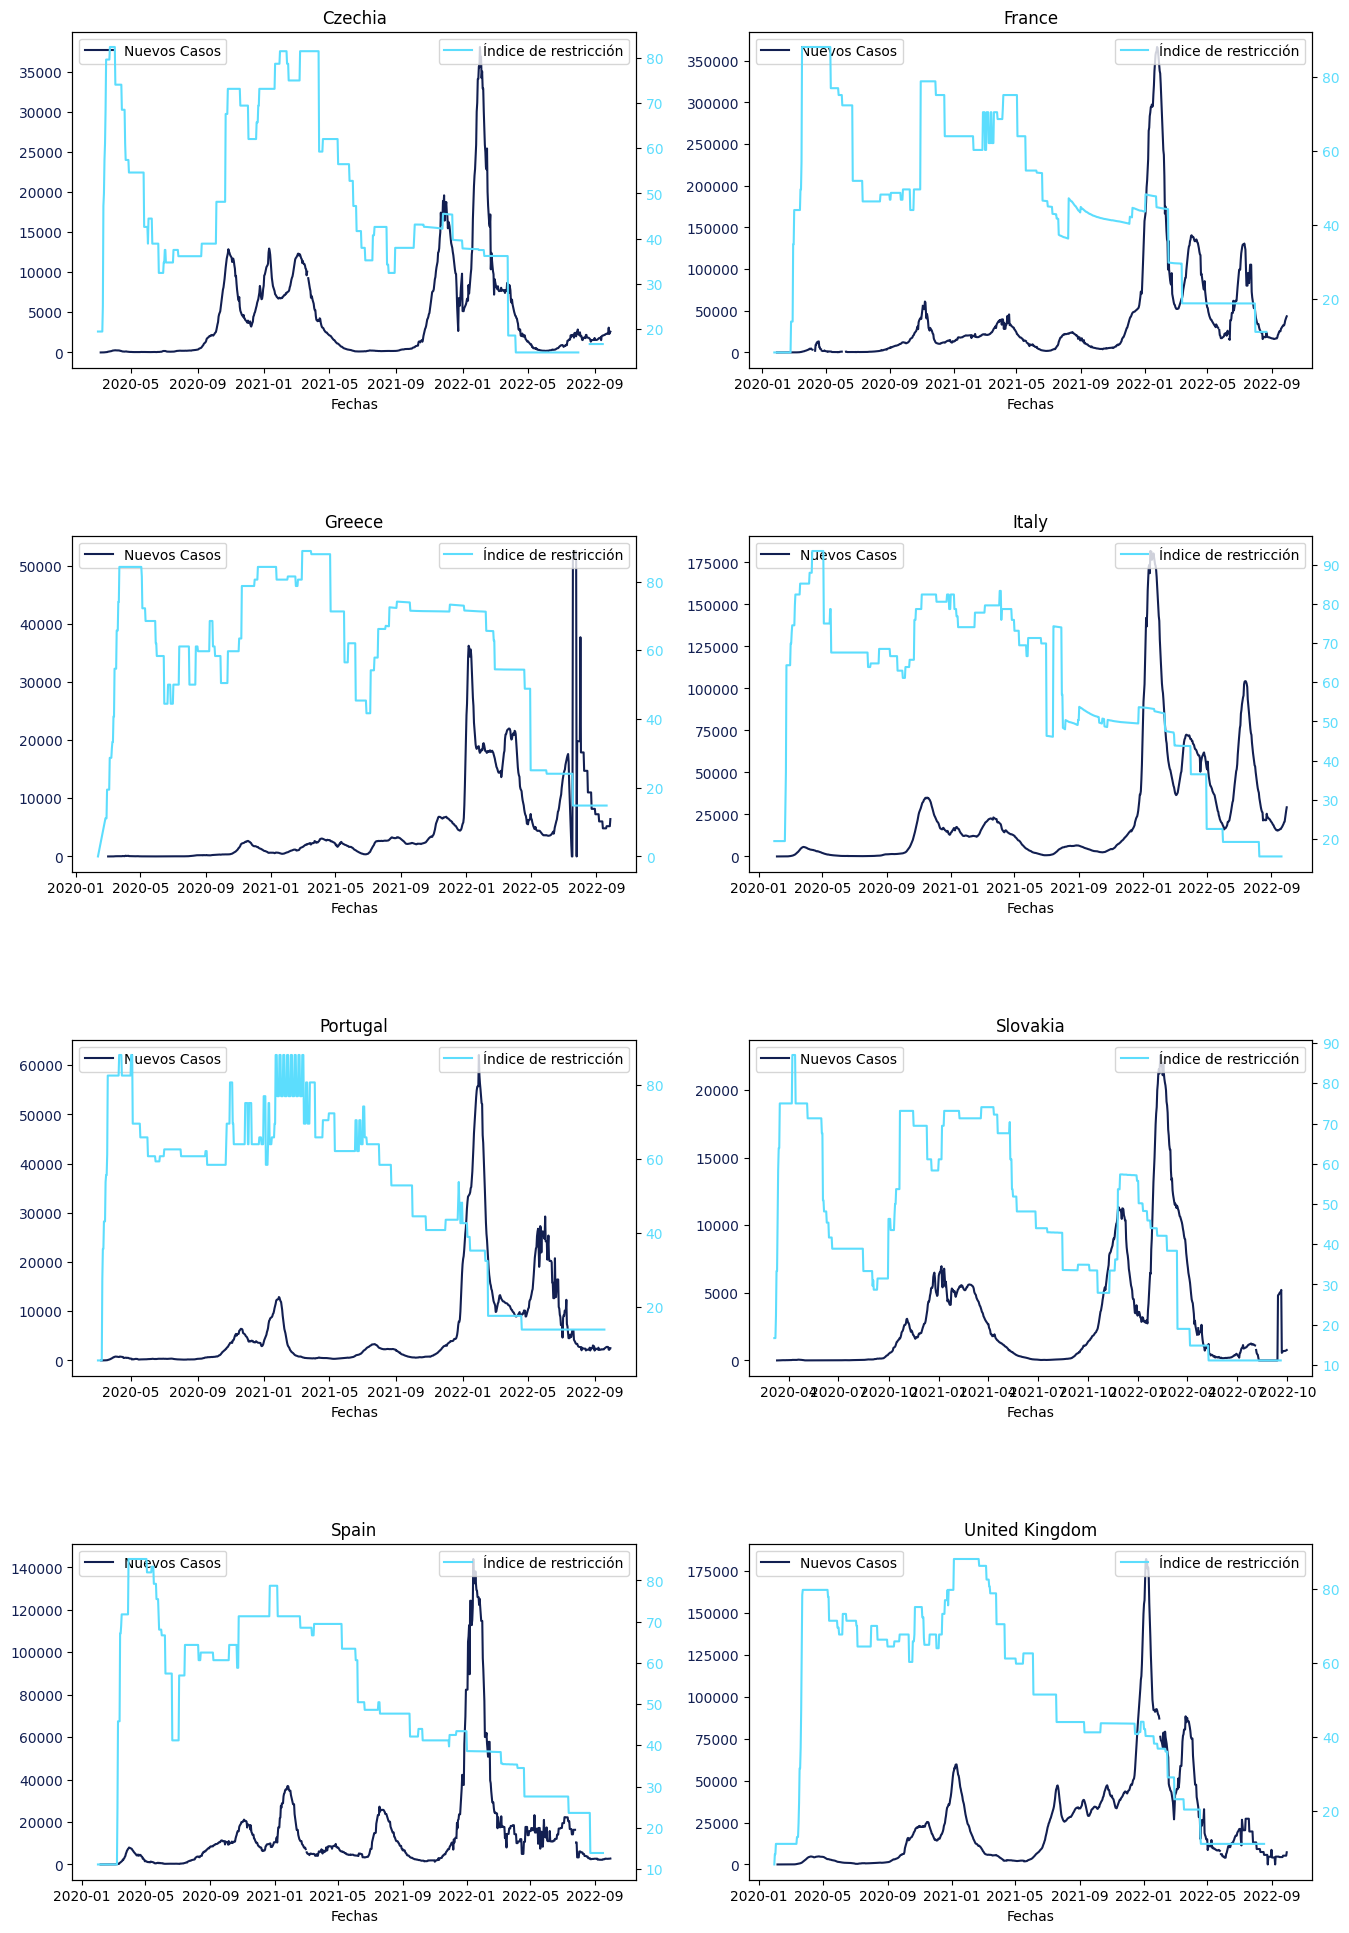

In [8]:
fig, axs = plt.subplots(nrows=math.ceil(len(df_paises['location'].unique())/2),ncols=2, figsize=(16, 3*len(df_paises['location'].unique())))
axs = axs.flatten()
plt.subplots_adjust(hspace=0.5)
plt.rcParams['font.family'] = 'Sans'

# Iterar sobre cada país y crear un gráfico separado para cada uno
for i, (pais, grupo) in enumerate(paises):
    ax1 = axs[i]
    ax2 = ax1.twinx()

    # Graficar el primer conjunto de datos (nuevos casos)
    ax1.plot(grupo['date'], grupo['new_cases_smoothed'], color='#121f51', label='Nuevos Casos')
    # Graficar el segundo conjunto de datos (Índice de restricción)
    ax2.plot(grupo['date'], grupo['stringency_index'], color='#5cddfd', label='Índice de restricción')
    
    #ax1.set_ylabel('Nuevos Casos', color='blue')
    #ax2.set_ylabel('Índice de restricción', color='red')
    ax1.tick_params(axis='y', labelcolor='#121f51')
    ax2.tick_params(axis='y', labelcolor='#5cddfd')
    ax1.set_title(pais)
    ax1.set_xlabel('Fechas')

    # Agregar leyenda y mostrar el gráfico
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
plt.show()

### Analisis de las graficas

#### Podemos notar en estas graficas que usuamente al bajar el indice de reestriccion en cada pais se pueden notar incrementos en los casos nuevos, con esto a simple vista podemos llegar a intuir que las restricciones aplicadas por pais si dan resultado, pero esta tambien es una primera instacia de analisis quedan muchos datos mas por analizar a lo largo del proyecto.

# 2.5 Grafico de nuevas muertes por pais vs vacunaciones 

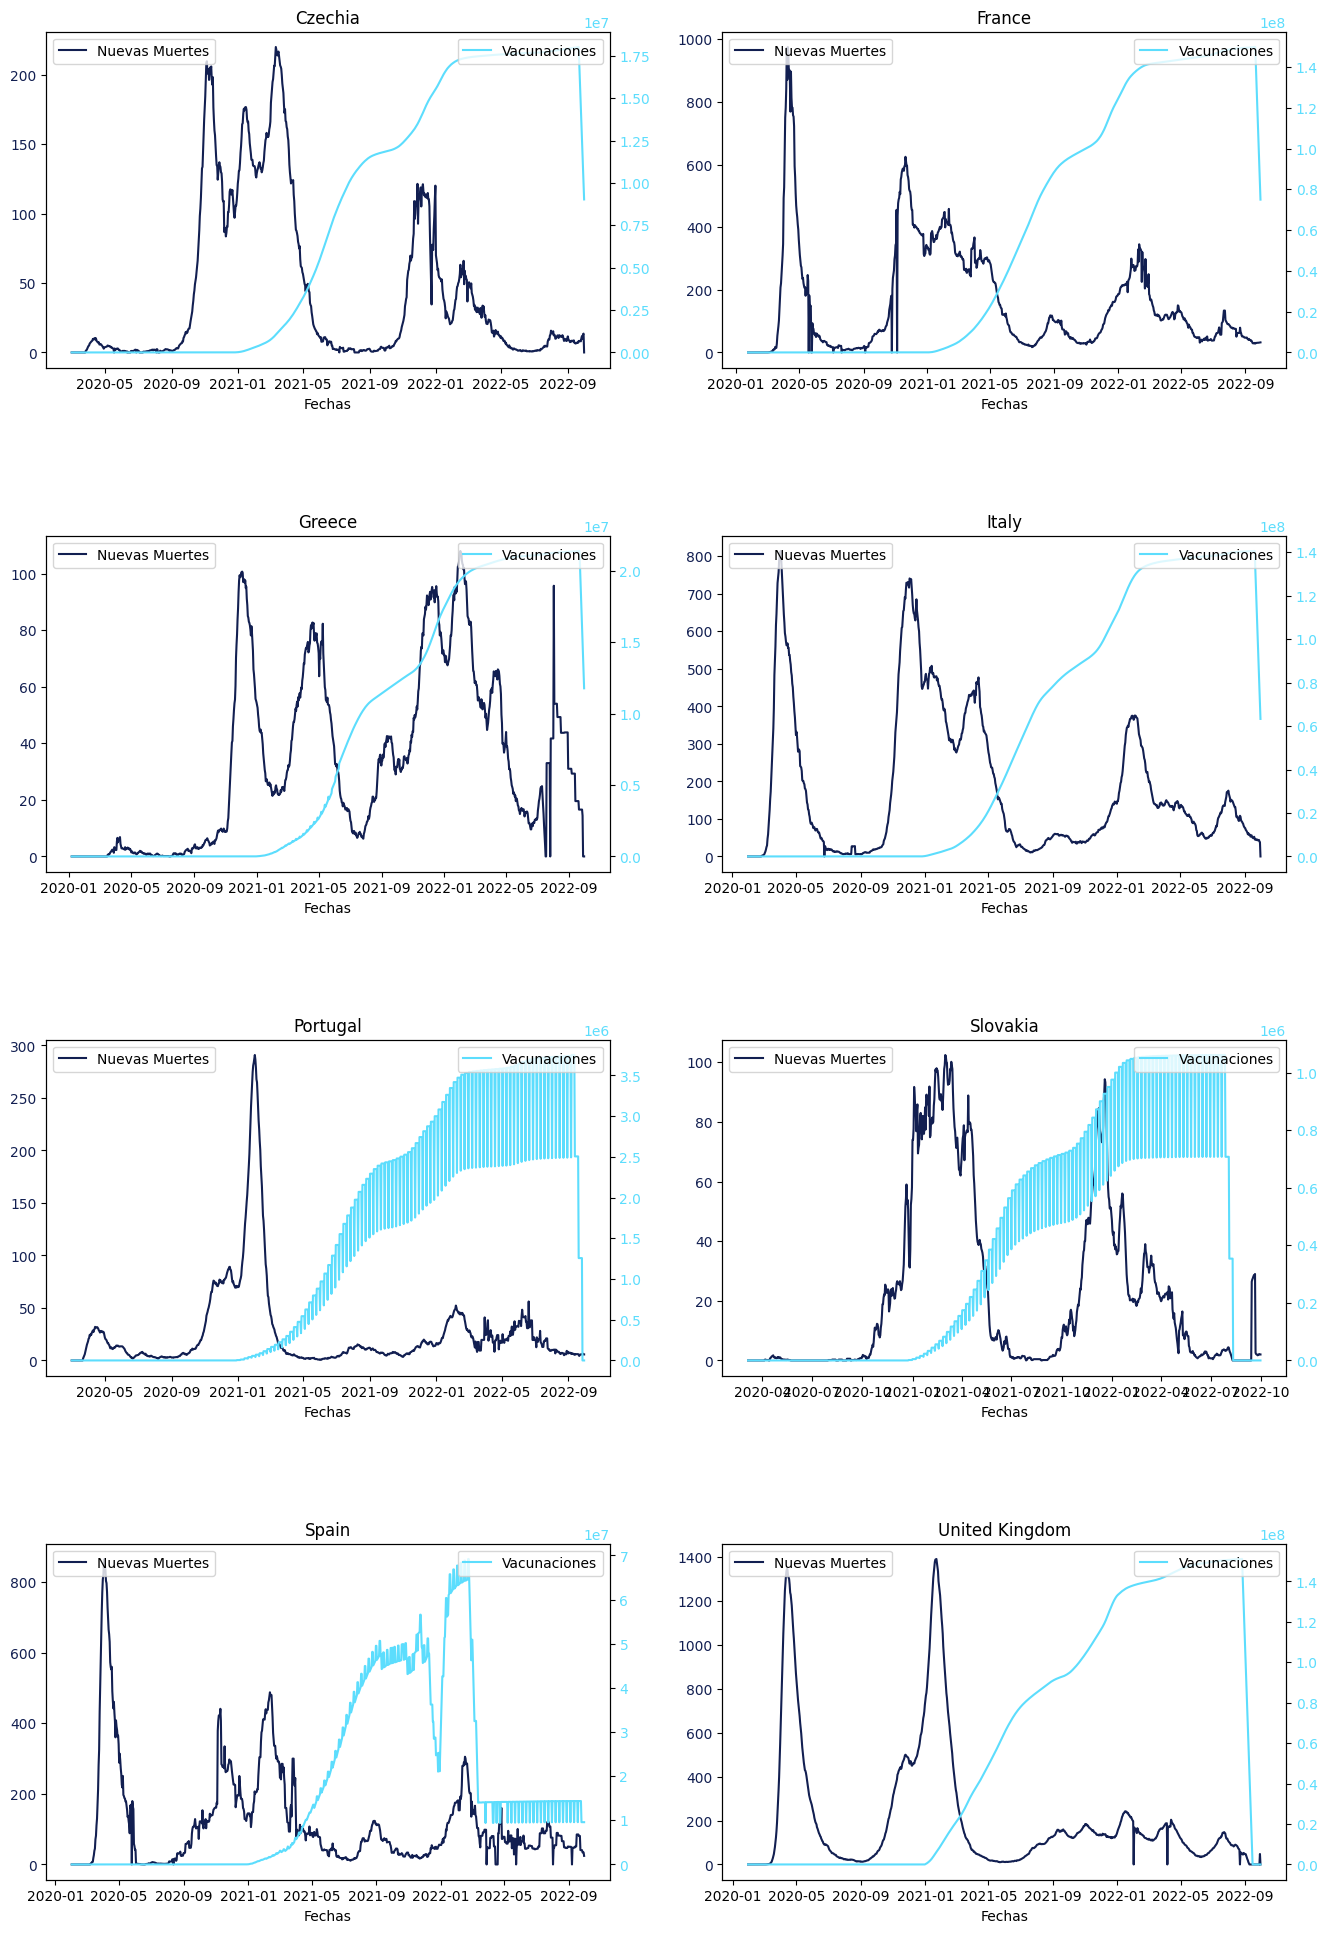

In [46]:
fig, axs = plt.subplots(nrows=math.ceil(len(df_paises['location'].unique())/2),ncols=2, figsize=(16, 3*len(df_paises['location'].unique())))
axs = axs.flatten()
plt.subplots_adjust(hspace=0.5)
plt.rcParams['font.family'] = 'Sans'




# Iterar sobre cada país y crear un gráfico separado para cada uno
for i, (pais, grupo) in enumerate(paises):
    ax1 = axs[i]
    ax2 = ax1.twinx()
    # y_smooth = np.convolve(grupo['total_vaccinations'], np.ones(20)/20, mode='same')

    # Graficar el primer conjunto de datos
    ax1.plot(grupo['date'], grupo['new_deaths_smoothed'], color='#121f51', label='Nuevas Muertes')
    # Graficar el segundo conjunto de datos
    ax2.plot(grupo['date'],grupo['total_vaccinations'], color='#5cddfd', label='Vacunaciones')    
    
    ax1.tick_params(axis='y', labelcolor='#121f51')
    ax2.tick_params(axis='y', labelcolor='#5cddfd')
    ax1.set_title(pais)
    ax1.set_xlabel('Fechas')

    # Agregar leyenda y mostrar el gráfico
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
plt.show()

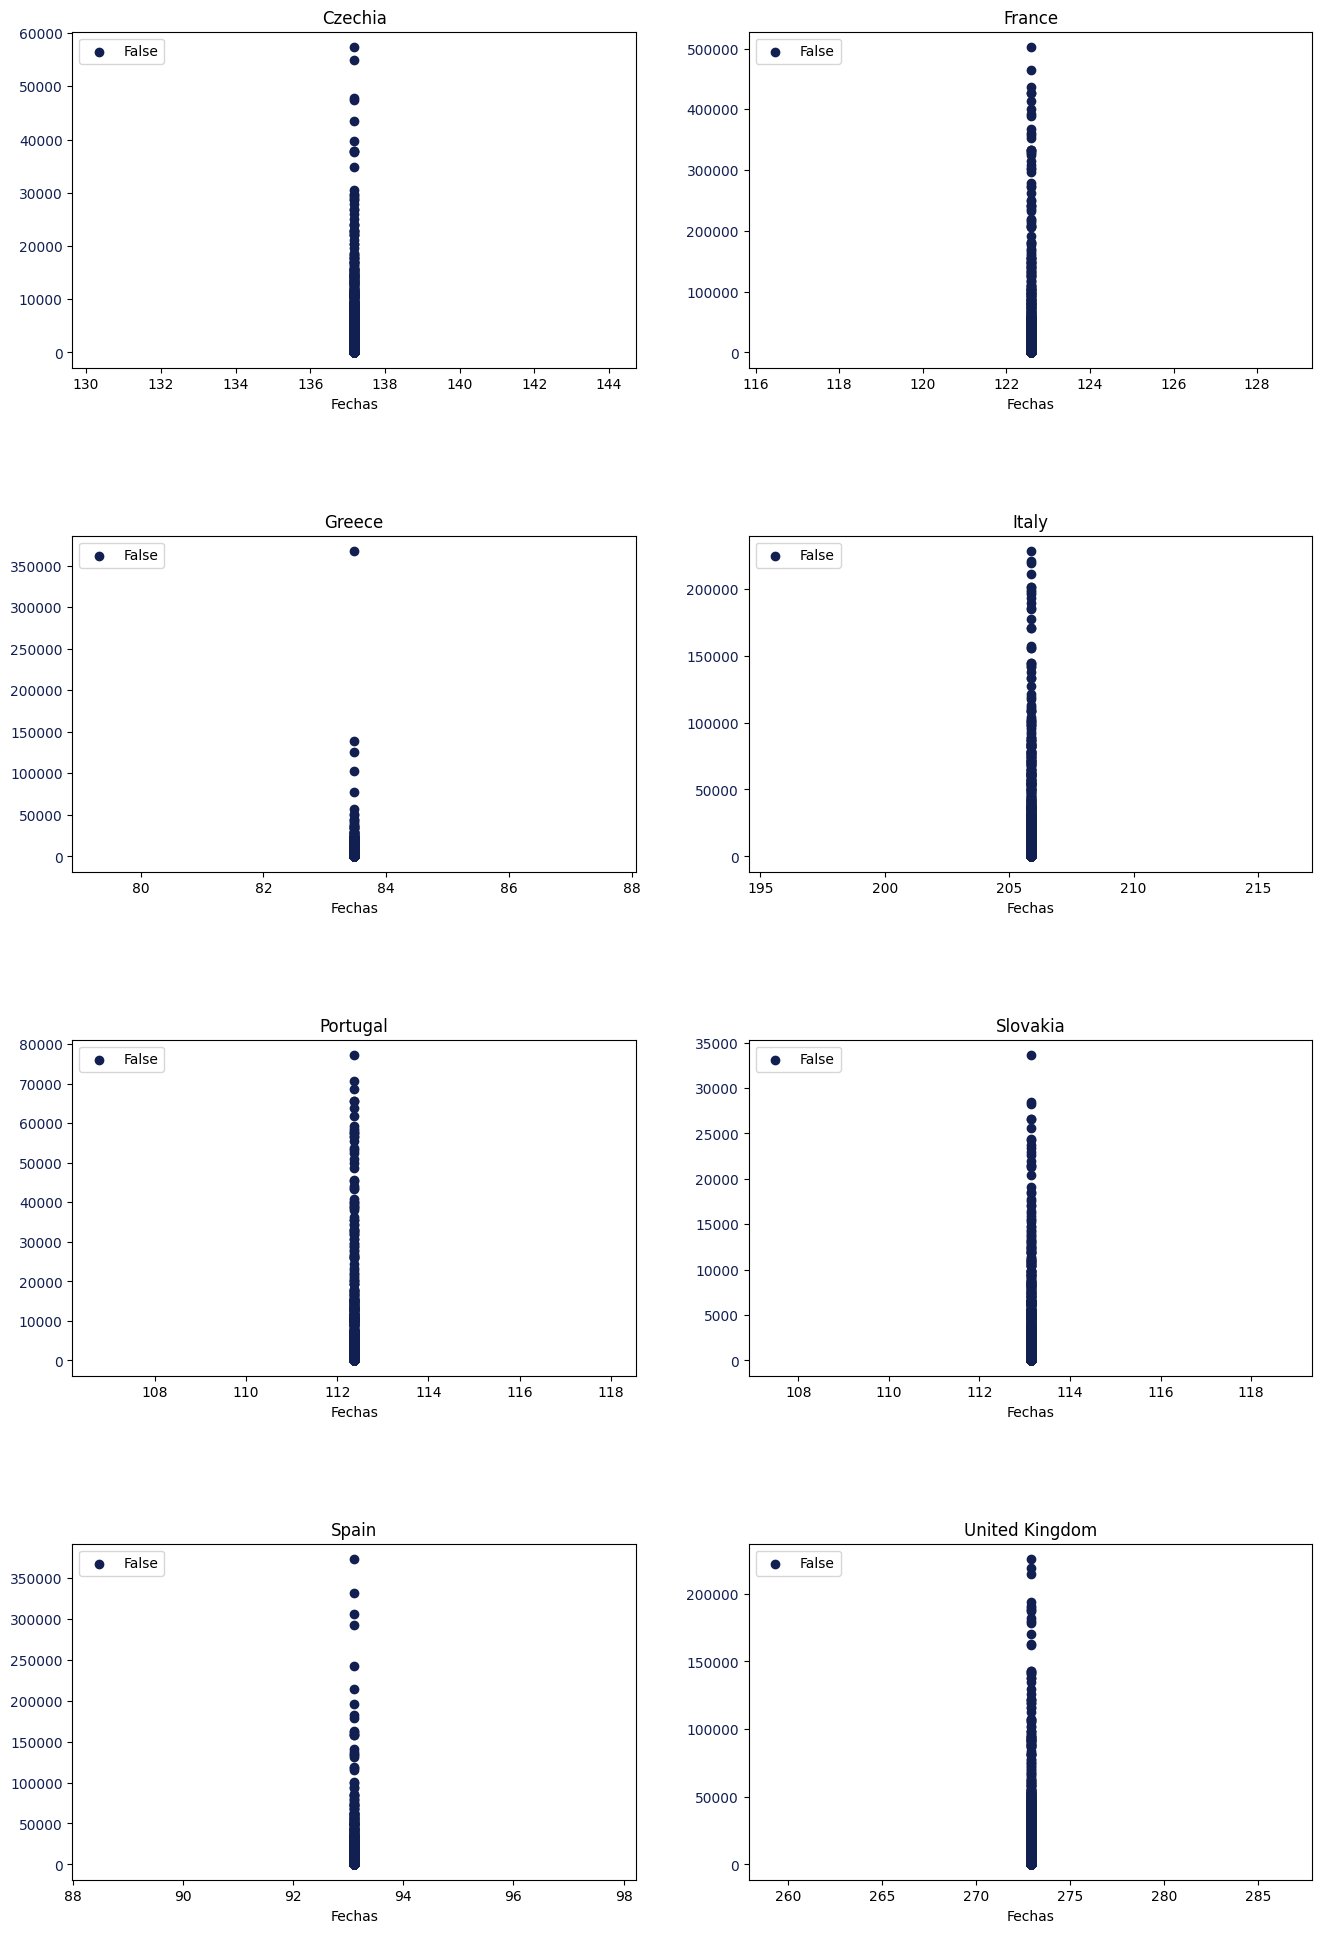

In [54]:
fig, axs = plt.subplots(nrows=math.ceil(len(df_paises['location'].unique())/2),ncols=2, figsize=(16, 3*len(df_paises['location'].unique())))
axs = axs.flatten()
plt.subplots_adjust(hspace=0.5)
plt.rcParams['font.family'] = 'Sans'


for i, (pais, grupo) in enumerate(paises):
    ax1 = axs[i]
    #ax2 = ax1.twinx()
    # y_smooth = np.convolve(grupo['total_vaccinations'], np.ones(20)/20, mode='same')

    # Graficar el primer conjunto de datos
    ax1.scatter(grupo['population_density'], grupo['new_cases'], color='#121f51',label = False)
    # Graficar el segundo conjunto de datos
    #ax2.plot(grupo['date'],grupo['total_vaccinations'], color='#5cddfd', label='Vacunaciones')    
    
    ax1.tick_params(axis='y', labelcolor='#121f51')
    #ax2.tick_params(axis='y', labelcolor='#5cddfd')
    ax1.set_title(pais)
    ax1.set_xlabel('Fechas')

    # Agregar leyenda y mostrar el gráfico
    ax1.legend(loc='upper left')
    #ax2.legend(loc='upper right')
plt.show()



#### En estas graficas podemos obsevar las muertes por pais a lo largo del tiempo, podemos observar como hay una tendecia a en los meses finales del 2020 a crecer la cantidad de muertos en estos paises, 

## 2.6 Grafico de maximos de testeos por pais 

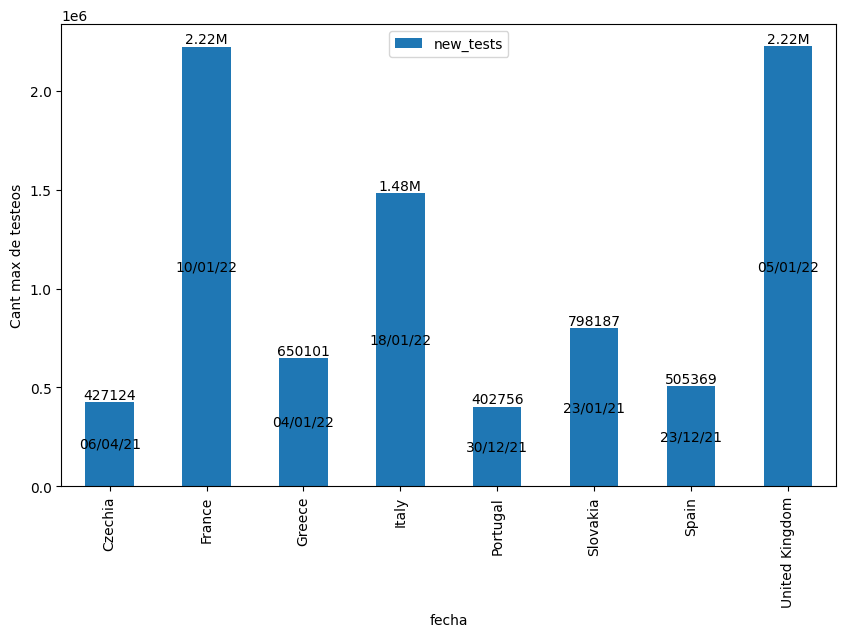

In [42]:
import matplotlib.dates as mdates
#f2 = copy_df.dropna(subset=['new_tests'])
max_test = paises['new_tests'].idxmax()

max_row_test = df_paises.loc[max_test]
max_row_test['date_str'] = max_row_test['date'].dt.strftime('%d/%m/%y') # Crear una nueva columna con la fecha en formato 'D/M/YY'
#df_grouped = paises.max()

ax = max_row_test.plot(kind='bar', y='new_tests',x='location',figsize=(10,6))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))#fomateo de la fecha 
plt.xlabel('fecha')
plt.ylabel('Cant max de testeos')

# Función para formatear los valores de las etiquetas
def millions_format(x):          
          if (x >1000000):
                    return f'{round(float(x/1000000),2)}M'
          

# Iteramos sobre las barras para agregar las etiquetas
for i in ax.containers:
    values = i.datavalues   
    labels = [millions_format(value) for value in values]
    ax.bar_label(i, labels=labels, label_type='edge', fontsize=10)
    ax.bar_label(i,labels=max_row_test['date_str'],label_type='center')
    
plt.show()

#### En este grafico podemos observar los maximos testados en un dia y a su vez en el medio de la barra podemos ver el dia en que se dio esta cantidad de testeos.

# 2.7 Grafico barras de total de vacunados por pais

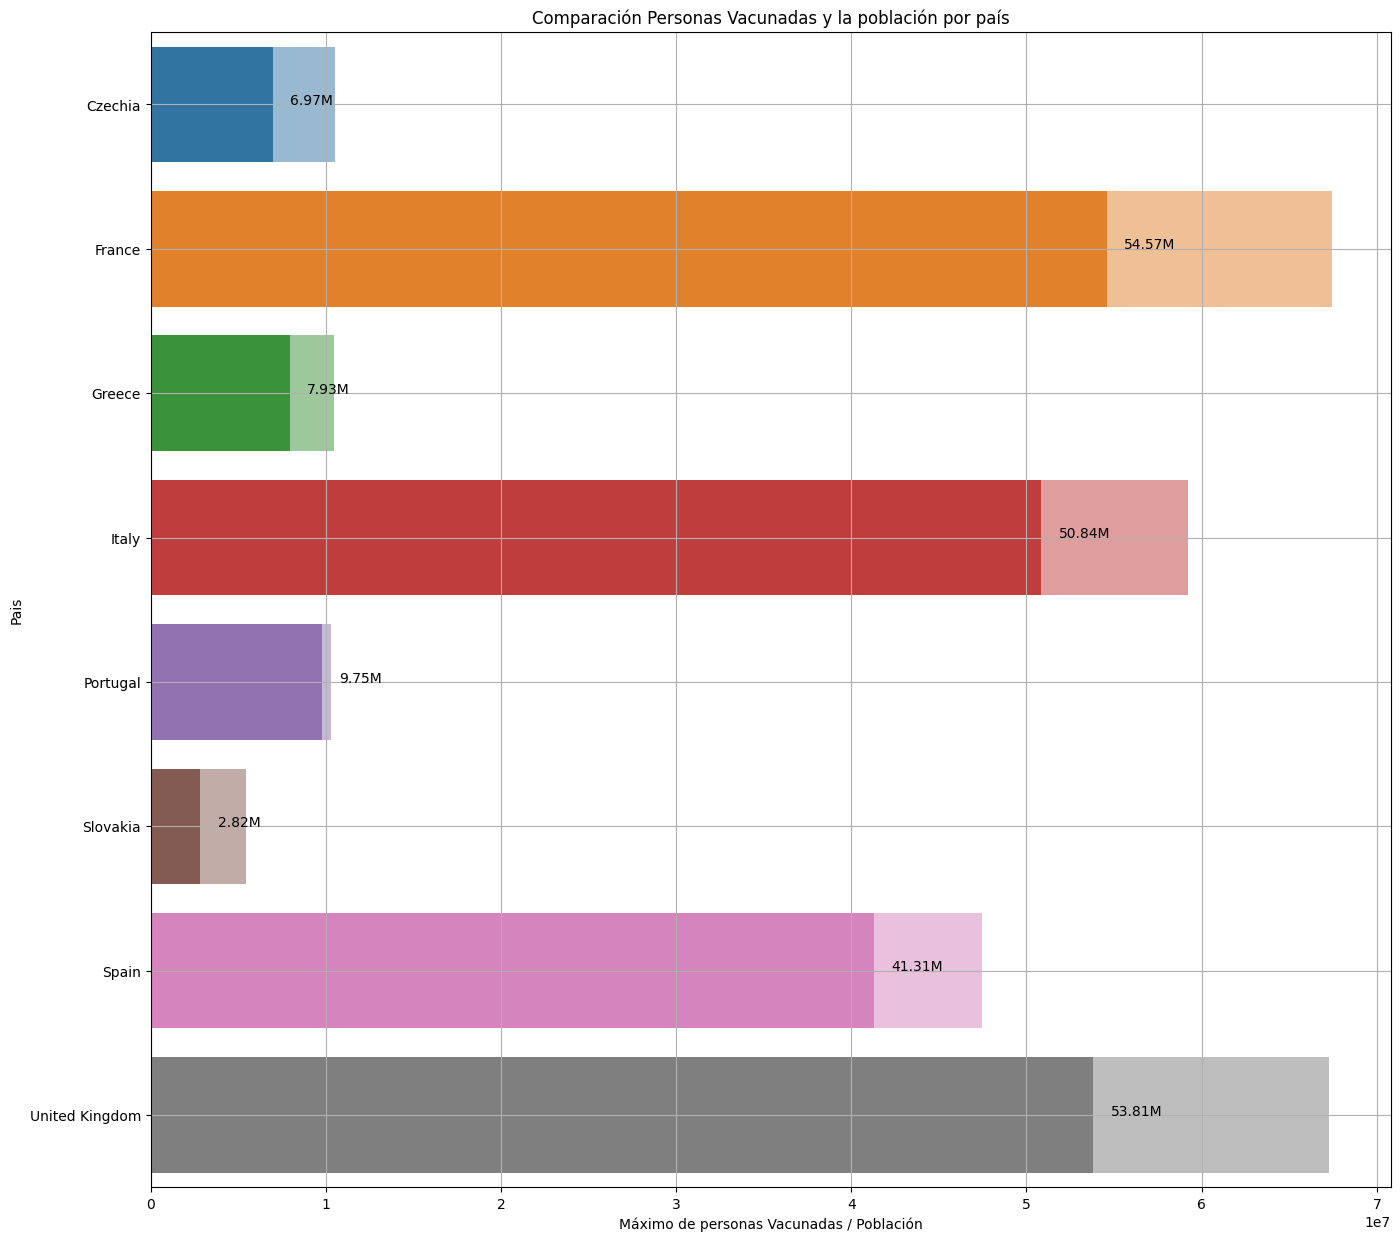

In [39]:

plt.figure(figsize=(16,15))
df_grouped = paises.max()

ax = sns.barplot(y=df_grouped.index, x='population', data=df_grouped,  alpha = 0.5)

#sns.barplot(y=df_grouped.index, x='population', data=df_grouped,  alpha = 0.5)
sns.barplot(y=df_grouped.index, x='people_vaccinated', data=df_grouped )

for i, value in enumerate(df_grouped['people_vaccinated']):
    ax.annotate(f'{round(float(value/1000000),2)}M', (value+1000000, i), ha='left', fontsize=10)

plt.grid()
plt.xlabel('Máximo de personas Vacunadas / Población')
plt.ylabel('Pais')
plt.title('Comparación Personas Vacunadas y la población por país')
plt.show()

#### En este grafico podemos ver la compracion entre las personas vacunas en cada pais contra la poblacion total del pais. Los valores impresos en la grafica son los correspondientes a las personas vacunadas

# 2.8 Grafico de ingresos al hopital vs ingresos a terapia intesiva


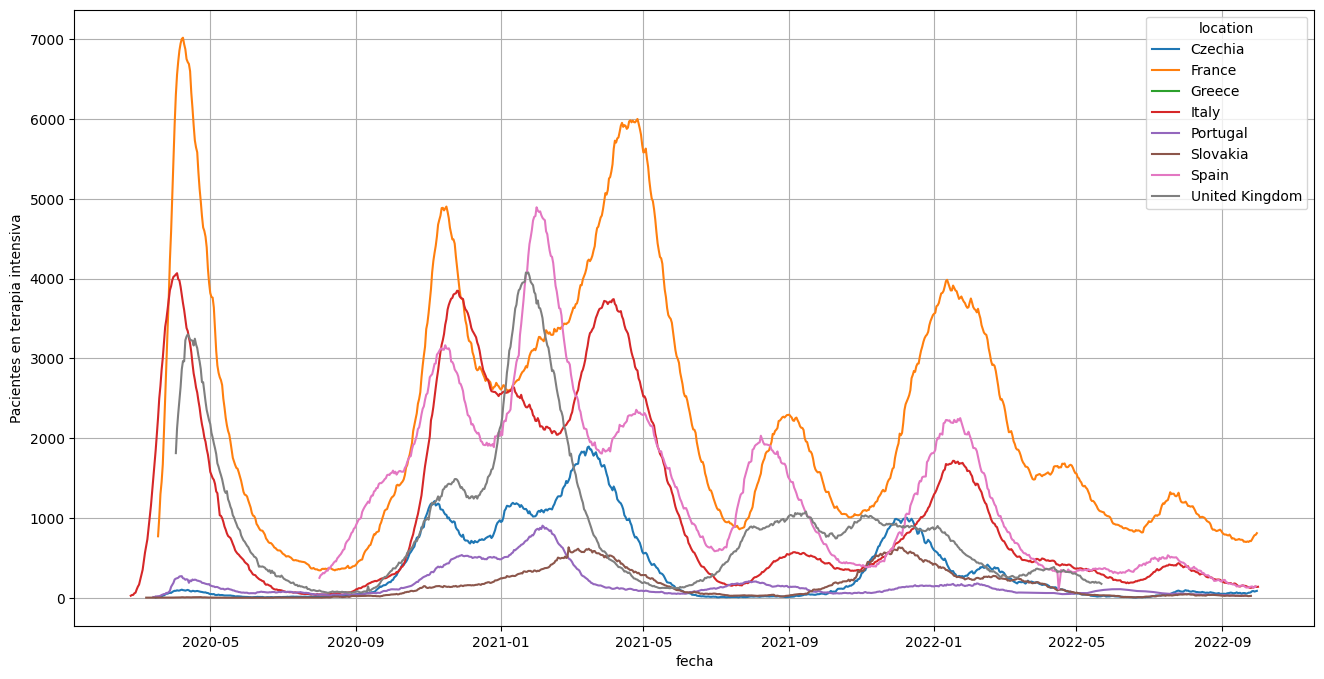

In [12]:
plt.figure(figsize=(16,8))

sns.lineplot(x='date', y='icu_patients', data=df_paises, hue='location')
plt.grid()
plt.xlabel('fecha')
plt.ylabel('Pacientes en terapia intensiva')
plt.title('')
plt.show()

#### Este grafico muestrs por fecha la cantidad de pacientes que ingresaron a la terapia intesiva por pais 

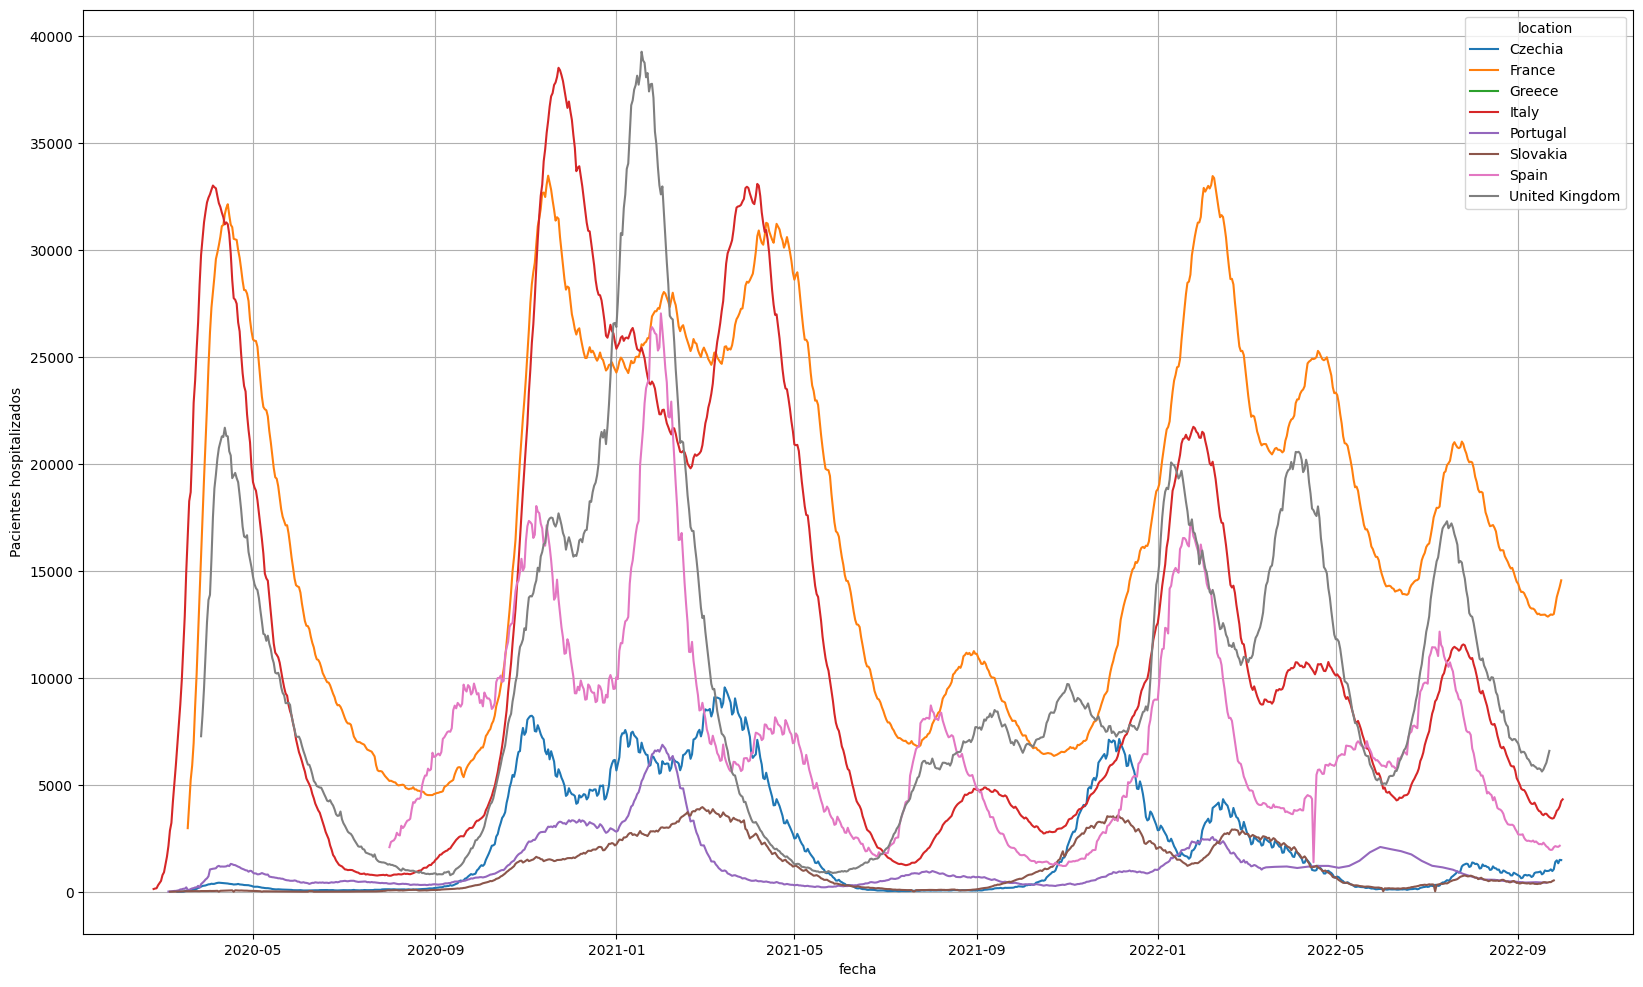

In [13]:
plt.figure(figsize=(20,12))

sns.lineplot(x='date', y='hosp_patients', data=df_paises,hue='location')
plt.grid()
plt.xlabel('fecha')
plt.ylabel('Pacientes hospitalizados')
plt.title('')
plt.show()

#### Este grafico es similar al anterior pero muestra las personas que fueron solamente hospitalizadas

# 3. Featured Selection 

## 3.1 Definicion de las funciones a utilizar

In [14]:
import statsmodels.api as sm1

#foward selection

def forward_selection(data, target, significance_level=0.01):
    initial_features = data.columns.tolist() # lista con columnas
    best_features = [] # lista vacia para guardar features significativos
    while (len(initial_features)>0): # siempre y cuando esto sea mayor que 0 seguir
        remaining_features = list(set(initial_features)-set(best_features)) # operacion diferencia todas - features que van saliendo
        new_pval = pd.Series(index=remaining_features) # seria para guardar p valores
        for new_column in remaining_features: # para las columnas restates seguir evaluando
            model = sm1.OLS(target, sm1.add_constant(data[best_features+[new_column]])).fit() # ajustar el modelo con target agregando columnas de una en una
            new_pval[new_column] = model.pvalues[new_column] # agregar a la serie el p valor para cada feature
        min_p_value = new_pval.min() # encontrar el p valor minimo (mas significativo)
        if(min_p_value<significance_level): # verificar si es menor a alpha
            best_features.append(new_pval.idxmin()) # agregar el nombre del feature
        else:
            break # cuando no se cumpla la condicion parar y salir
    return best_features

#Bidireccional

def stepwise_selection(data, target,SL_in=0.05,SL_out = 0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm1.OLS(target, sm1.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm1.add_constant(data[best_features])
                p_values = sm1.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break 
        else:
            break
    return best_features

#backward 

def backward_elimination(data, target,significance_level = 0.05):
    features = data.columns.tolist() # arrancamos con todas las columnas
    while(len(features)>0): # siempre y cuando haya mas de 1 feature seguir
        features_with_constant = sm1.add_constant(data[features]) # hacer el modelo con todas las variables e ir removiendo
        p_values = sm1.OLS(target, features_with_constant).fit().pvalues[1:] # ajustar el modelo y sacar p valores
        max_p_value = p_values.max() # sacar el p valor maximo
        if(max_p_value >= significance_level): # verificar si es mayor a la significancia
            excluded_feature = p_values.idxmax() # de ser asi remover el feature por ser no significativo
            features.remove(excluded_feature) # remover de la lista de fetures
        else:
            break 
    return features


In [15]:
df_paises.fillna(0,inplace=True)
X = df_paises.drop(['new_cases','new_cases_smoothed','iso_code', 'continent', 'location', 'date','tests_units'], axis=1)
Y= df_paises['new_cases']

C:\Users\Ignacio\AppData\Local\Temp\ipykernel_139144\2138695627.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paises.fillna(0,inplace=True)


##### Aca separamos la colunma objetivo del resto de colunmas

In [16]:
import numpy as np
from scipy import stats
# IQR
q1 = X.quantile(0.25)
q3 = X.quantile(0.75)
iqr = q3 - q1
X_r= X.copy()
X_r['outlier_iqr'] = X_r.apply(lambda row: 1 if any(np.abs(row - q3) > 1.5*iqr) else 0, axis=1)
# Tukey
med = X.median()
X_r['outlier_tukey']=X_r.drop(columns='outlier_iqr').apply(lambda row: 1 if any(np.abs(row - med) > 1.5*iqr) else 0, axis=1)
X_r

,total_cases,total_deaths,new_deaths,new_deaths_smoothed,reproduction_rate,icu_patients,hosp_patients,weekly_icu_admissions,weekly_hosp_admissions,total_tests,...,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,Porcentaje_contagios,outlier_iqr,outlier_tukey
50373,3.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,6.63,79.38,0.900,-1175.2,-5.29,-5.92,-111.809338,0.000029,1,1
50374,3.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,6.63,79.38,0.900,0.0,0.00,0.00,0.000000,0.000029,1,1
50375,5.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,6.63,79.38,0.900,0.0,0.00,0.00,0.000000,0.000048,1,1
50376,8.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,6.63,79.38,0.900,0.0,0.00,0.00,0.000000,0.000076,1,1
50377,12.0,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,6.63,79.38,0.900,0.0,0.00,0.00,0.000000,0.000114,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207698,23621956.0,206652.0,0.0,0.000,0.50,0.0,0.0,0.0,0.0,0.0,...,2.54,81.32,0.932,0.0,0.00,0.00,0.000000,35.109380,1,1
207699,23621956.0,206532.0,0.0,0.000,0.49,0.0,0.0,0.0,0.0,0.0,...,2.54,81.32,0.932,0.0,0.00,0.00,0.000000,35.109380,1,1
207700,23621956.0,206532.0,0.0,0.000,0.49,0.0,0.0,0.0,0.0,0.0,...,2.54,81.32,0.932,0.0,0.00,0.00,0.000000,35.109380,1,1
207701,23672856.0,206865.0,333.0,47.571,0.00,0.0,0.0,0.0,0.0,0.0,...,2.54,81.32,0.932,0.0,0.00,0.00,0.000000,35.185033,1,1


In [17]:
X_r['outlier_iqr'].value_counts()

1    7399
0     284
Name: outlier_iqr, dtype: int64

In [18]:
X_r['outlier_tukey'].value_counts()

1    7300
0     383
Name: outlier_tukey, dtype: int64

In [19]:
X_r[~((X_r['outlier_iqr']==1) & (X_r['outlier_tukey']==1))]
indexes=X_r[~((X_r['outlier_iqr']==1) & (X_r['outlier_tukey']==1))].index

In [20]:
X_n= X.loc[indexes]
y_n= Y.loc[indexes]

In [21]:
y_n.shape

(516,)

In [22]:
X_n.shape

(516, 42)

# 4.1 Modelos

In [23]:
import warnings #new cases
warnings.filterwarnings("ignore")
forward_selection(X,Y)

['total_vaccinations',
 'weekly_hosp_admissions',
 'new_tests_smoothed',
 'positive_rate',
 'total_boosters',
 'population_density',
 'total_tests',
 'people_fully_vaccinated',
 'new_deaths_smoothed',
 'new_deaths',
 'new_vaccinations',
 'people_vaccinated',
 'human_development_index',
 'hosp_patients',
 'stringency_index',
 'total_deaths',
 'total_cases',
 'life_expectancy',
 'new_vaccinations_smoothed',
 'excess_mortality_cumulative_absolute',
 'new_tests',
 'female_smokers',
 'male_smokers',
 'new_people_vaccinated_smoothed']

In [24]:
modelE  = 'new_cases_smoothed~ + total_boosters + weekly_hosp_admissions  + icu_patients + new_deaths + new_deaths_smoothed + new_tests + positive_rate + population + population_density  + people_fully_vaccinated + aged_65_older + total_tests + hospital_beds_per_thousand +  diabetes_prevalence + diabetes_prevalence + extreme_poverty + new_vaccinations + median_age + total_vaccinations+ new_vaccinations_smoothed + people_vaccinated + female_smokers '

lmE = sm.ols(formula=modelE , data= df_paises.query('location in ["United Kingdom"]'))

result = lmE.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     new_cases_smoothed   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     444.9
Date:                Sat, 20 May 2023   Prob (F-statistic):               0.00
Time:                        14:14:16   Log-Likelihood:                -10467.
No. Observations:                 975   AIC:                         2.096e+04
Df Residuals:                     961   BIC:                         2.103e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [25]:
warnings.filterwarnings("ignore") #new cases
backward_elimination(X,Y)

['total_cases',
 'total_deaths',
 'new_deaths',
 'new_deaths_smoothed',
 'icu_patients',
 'hosp_patients',
 'weekly_icu_admissions',
 'weekly_hosp_admissions',
 'total_tests',
 'new_tests',
 'new_tests_smoothed',
 'positive_rate',
 'total_vaccinations',
 'people_vaccinated',
 'people_fully_vaccinated',
 'total_boosters',
 'new_vaccinations',
 'new_vaccinations_smoothed',
 'new_people_vaccinated_smoothed',
 'stringency_index',
 'population',
 'population_density',
 'aged_65_older',
 'cardiovasc_death_rate',
 'diabetes_prevalence',
 'female_smokers',
 'excess_mortality_cumulative_absolute',
 'excess_mortality_cumulative',
 'excess_mortality',
 'excess_mortality_cumulative_per_million']

In [26]:
modelE  = 'new_cases_smoothed~ total_cases + total_deaths + new_deaths + new_deaths_smoothed + icu_patients + hosp_patients + weekly_hosp_admissions + total_tests + new_tests + positive_rate + total_vaccinations + people_vaccinated + total_boosters + new_vaccinations + new_vaccinations_smoothed + stringency_index + population + population_density + aged_70_older + cardiovasc_death_rate + female_smokers + male_smokers + handwashing_facilities + hospital_beds_per_thousand + excess_mortality_cumulative_absolute + excess_mortality_cumulative + excess_mortality + excess_mortality_cumulative_per_million '

lmE = sm.ols(formula=modelE , data= df_paises.query('location in ["United Kingdom"]'))

result = lmE.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     new_cases_smoothed   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     242.9
Date:                Sat, 20 May 2023   Prob (F-statistic):               0.00
Time:                        14:14:16   Log-Likelihood:                -10558.
No. Observations:                 975   AIC:                         2.116e+04
Df Residuals:                     955   BIC:                         2.125e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [27]:
warnings.filterwarnings("ignore") #new cases
stepwise_selection(X,Y) 

['total_vaccinations',
 'weekly_hosp_admissions',
 'new_tests_smoothed',
 'positive_rate',
 'total_boosters',
 'total_tests',
 'people_fully_vaccinated',
 'new_deaths_smoothed',
 'new_deaths',
 'new_vaccinations',
 'people_vaccinated',
 'human_development_index',
 'hosp_patients',
 'stringency_index',
 'total_deaths',
 'total_cases',
 'life_expectancy',
 'new_vaccinations_smoothed',
 'excess_mortality_cumulative_absolute',
 'new_tests',
 'diabetes_prevalence',
 'new_people_vaccinated_smoothed',
 'tests_per_case']

In [28]:
modelE  = 'new_cases_smoothed~ weekly_hosp_admissions + icu_patients + new_deaths + new_deaths_smoothed + new_tests + positive_rate + population_density + total_cases + people_fully_vaccinated + aged_65_older + median_age + extreme_poverty + total_tests + Porcentaje_contagios + diabetes_prevalence + new_tests_smoothed + total_vaccinations + new_vaccinations_smoothed + new_vaccinations + total_boosters + tests_per_case + reproduction_rate + people_vaccinated + life_expectancy'
lmE = sm.ols(formula=modelE , data= df_paises.query('location in ["United Kingdom"]'))

result = lmE.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     new_cases_smoothed   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     573.5
Date:                Sat, 20 May 2023   Prob (F-statistic):               0.00
Time:                        14:14:23   Log-Likelihood:                -10240.
No. Observations:                 975   AIC:                         2.052e+04
Df Residuals:                     957   BIC:                         2.060e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

# Evaluacion de Metricas

In [29]:
X_n = X_n[['total_boosters',
 'weekly_hosp_admissions',
 'icu_patients',
 'new_deaths',
 'new_deaths_smoothed',
 'new_tests',
 'positive_rate',
 'population',
 'population_density',
 'total_cases',
 'people_fully_vaccinated',
 'aged_65_older',
 'total_tests',
 'hospital_beds_per_thousand',
 'diabetes_prevalence',
 'extreme_poverty',
 'new_vaccinations',
 'median_age',
 'total_vaccinations',
 'new_vaccinations_smoothed',
 'people_vaccinated',
 'female_smokers']]

X_n.head(5)

,total_boosters,weekly_hosp_admissions,icu_patients,new_deaths,new_deaths_smoothed,new_tests,positive_rate,population,population_density,total_cases,...,total_tests,hospital_beds_per_thousand,diabetes_prevalence,extreme_poverty,new_vaccinations,median_age,total_vaccinations,new_vaccinations_smoothed,people_vaccinated,female_smokers
50402,0.0,260.0,73.0,7.0,3.143,0.0,0.0,10510750.0,137.176,3001.0,...,0.0,6.63,6.82,0.0,0.0,43.3,0.0,0.0,0.0,30.5
50403,0.0,279.0,82.0,8.0,4.000,0.0,0.0,10510750.0,137.176,3308.0,...,0.0,6.63,6.82,0.0,0.0,43.3,0.0,0.0,0.0,30.5
50404,0.0,276.0,88.0,8.0,4.714,0.0,0.0,10510750.0,137.176,3508.0,...,0.0,6.63,6.82,0.0,0.0,43.3,0.0,0.0,0.0,30.5
50405,0.0,266.0,87.0,5.0,5.000,0.0,0.0,10510750.0,137.176,3858.0,...,0.0,6.63,6.82,0.0,0.0,43.3,0.0,0.0,0.0,30.5
50406,0.0,267.0,94.0,9.0,6.286,0.0,0.0,10510750.0,137.176,4091.0,...,0.0,6.63,6.82,0.0,0.0,43.3,0.0,0.0,0.0,30.5


In [30]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_n,y_n,test_size=0.3,random_state=2)
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

In [31]:
from sklearn.metrics import mean_absolute_error
print("MAE",mean_absolute_error(y_test,y_pred))

MAE 1892.378945255723


In [32]:
from sklearn.metrics import mean_squared_error
print("MSE",mean_squared_error(y_test,y_pred))

MSE 10734597.99226197


In [33]:
print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE 3276.3696360853382


In [34]:
print("RMSE",np.log(np.sqrt(mean_squared_error(y_test,y_pred))))

RMSE 8.094491270135842


In [35]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print(r2)

0.4989042404334354
